## Exportando uma imagem

Este exemplo apresenta como iniciar exportar uma imagem para o Google Earth Engine ou para o Drive

### Importando a biblioteca Google Earth Engine

In [1]:
try:
    import ee 
except:
    !pip install earthengine-api
    import ee

In [2]:
# Instalando bibliotecas secundárias do OpenET

# Installing openet-core package
# https://github.com/Open-ET/openet-core

#    !pip install openet-core

# Installing openet.refetgee package
# https://github.com/Open-ET/openet-refet-gee

#    !pip install openet-refet-gee

### Inicializando Google Eaeth Engine
#### Necessário definir o projeto_id a ser utilizado

In [3]:
project_id = 'et-brasil'

try:
    ee.Initialize(project=project_id)
except:
    ee.Authenticate()

### Importando o modelo SSEBop e definido a localização do ambiente de trabalho 

In [4]:
import pprint
import sys
from IPython.display import Image

# Escolha o modelo:
model_name = 'ssebop'
sys.path.append(f'C:\openet_brazil\workshop_et_models\openet-{model_name}')

if model_name == 'ssebop':
    import openet.ssebop as model
elif model_name == 'geesebal':
    import openet.geesebal as model
elif model_name == 'ptjpl':
    import openet.ptjpl as model

### Variáveis de visualização

In [5]:
ndvi_palette = ['#EFE7E1', '#003300']
et_palette = [
    'DEC29B', 'E6CDA1', 'EDD9A6', 'F5E4A9', 'FFF4AD', 'C3E683', '6BCC5C', 
    '3BB369', '20998F', '1C8691', '16678A', '114982', '0B2C7A']
viridis_palette = ['440154', '433982', '30678D', '218F8B', '36B677', '8ED542', 'FDE725']
lst_palette = ['blue','green','yellow','orange','red']
area_de_interesse = ee.Geometry.Point([-47.2425,-17.5372]).buffer(20000)

image_size = 768

### Selecionando Imagem Landsat

In [6]:
landsat_img = ee.Image('LANDSAT/LC08/C02/T1_L2/LC08_220072_20210525')

landsat_crs = landsat_img.select('SR_B3').projection().getInfo()['crs']
landsat_region = landsat_img.geometry().bounds(1, 'EPSG:4326')
landsat_dt = ee.Date(landsat_img.get('system:time_start'))

### Visualização da composição natural

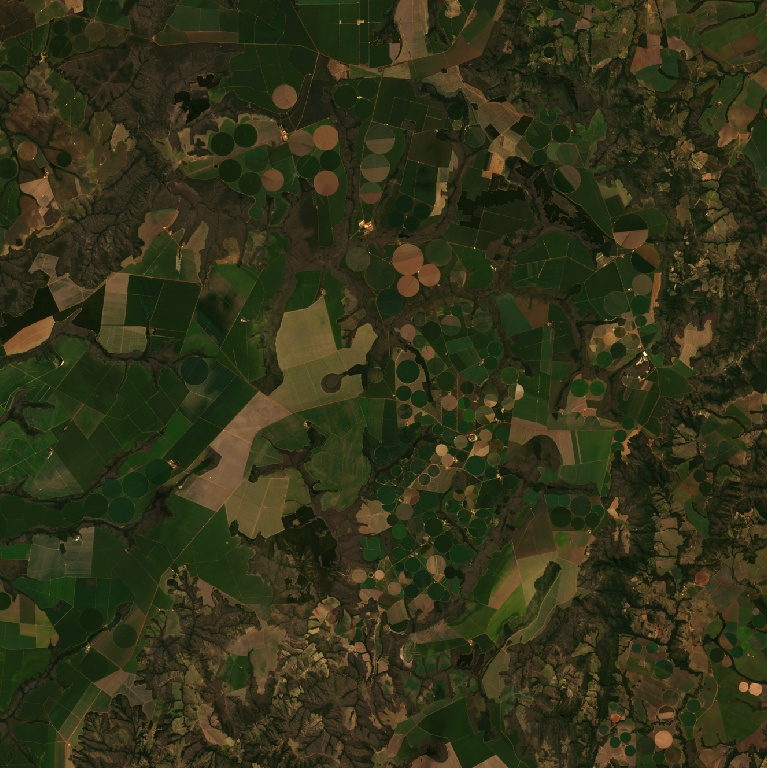

In [7]:
image_url = landsat_img.select(['SR_B4', 'SR_B3', 'SR_B2'])\
    .multiply([0.0000275, 0.0000275, 0.0000275])\
    .add([-0.2, -0.2, -0.2])\
    .getThumbURL({'min': 0.0, 'max': 0.3, 
                  'region': area_de_interesse, 'dimensions': image_size})
Image(image_url, embed=True, format='png')

### Criação do objeto do modelo

In [9]:
# Entradas
et_reference_source='projects/et-brasil/assets/era5/daily/etr'
et_reference_band='eto24h'
et_reference_factor=1.0
et_reference_resample='nearest'

# Build the SSEBop object from the Landsat image
if model_name == 'ssebop':
    model_obj = model.Image.from_landsat_c2_sr(
        landsat_img, 
        tcorr_source='FANO',
        et_reference_source=et_reference_source,
        et_reference_band=et_reference_band,
        et_reference_factor=et_reference_factor,
        et_reference_resample=et_reference_resample)

# Build the geeSEBAL   object from the Landsat image
if model_name == 'geesebal':
    model_obj = model.Image.from_landsat_c2_sr(
        landsat_img, 
        meteorology_source_inst='ECMWF/ERA5_LAND/HOURLY', 
        meteorology_source_daily='projects/openet/assets/meteorology/era5land/sa/daily',
        et_reference_source=et_reference_source,
        et_reference_band=et_reference_band,
        et_reference_factor=et_reference_factor,
        et_reference_resample=et_reference_resample)

# Build the PT-JPL   object from the Landsat image
if model_name == 'ptjpl':
    model_obj = model.Image.from_landsat_c2_sr(
        landsat_img,
        meteo_location='br',
        et_reference_source=et_reference_source,
        et_reference_band=et_reference_band,
        et_reference_factor=et_reference_factor,
        et_reference_resample=et_reference_resample)

### NDVI

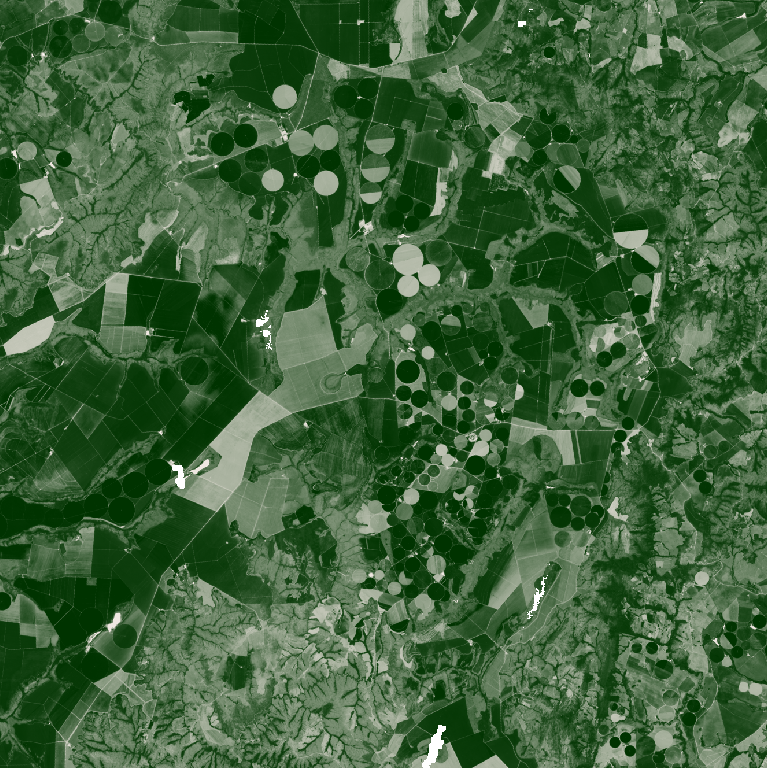

In [10]:
image_url = model_obj.ndvi\
    .getThumbURL({'min': 0, 'max': 0.9, 'palette': ndvi_palette, 
                  'region': area_de_interesse, 'dimensions': image_size})
Image(image_url, embed=True, format='png')

### LST

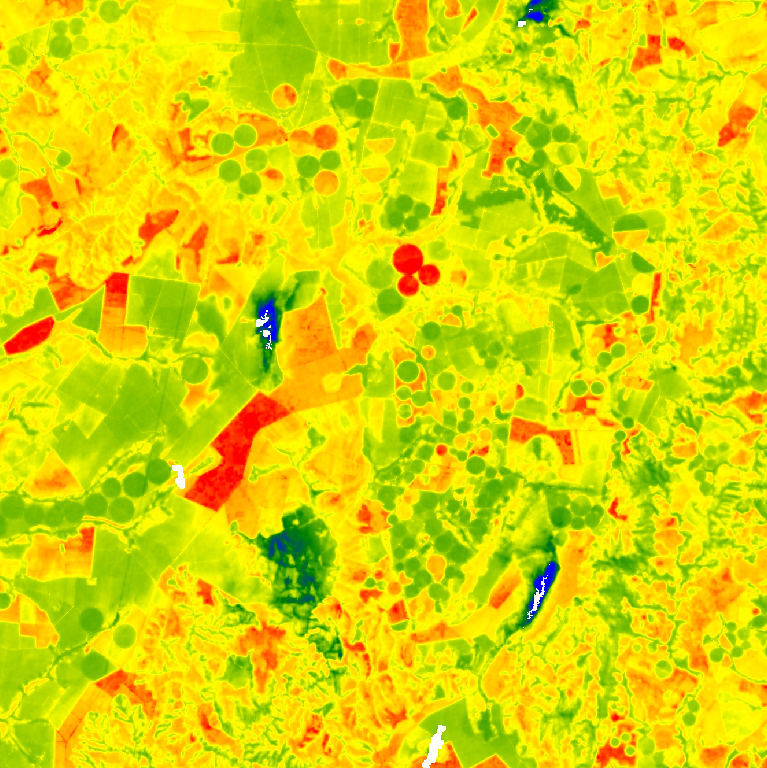

In [11]:
image_url = model_obj.lst\
    .getThumbURL({'min': 290, 'max': 315, 'palette': lst_palette, 
                  'region': area_de_interesse, 'dimensions': image_size})
Image(image_url, embed=True, format='png')

### ET

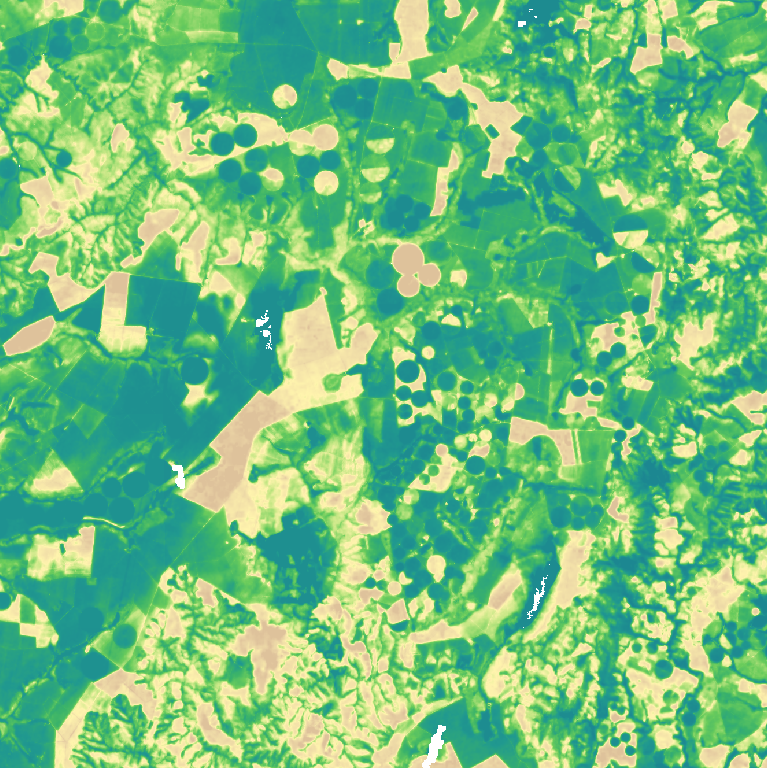

In [12]:
image_url = model_obj.et\
    .getThumbURL({'min': 0.0, 'max': 5, 'palette': et_palette, 
                  'region': area_de_interesse , 'dimensions': image_size})
Image(image_url, embed=True, format='png')

### Exportando para o drive

In [ ]:
task = ee.batch.Export.image.toDrive(
    image=model_obj.et,
    description='et_image_example',
    folder='workshop_ana',
    region=area_de_interesse,
    scale=30,
)
task.start()

### Exportando para o Google Earth Engine

In [ ]:
task = ee.batch.Export.image.toAsset(
    image=model_obj.et,
    assetId='projects/et-brasil/assets/imagem_exemplo',
    description='workshop_ana',
    region=area_de_interesse,
    scale=30,
)
task.start()